In [1]:
# Some setup code for imports
import os
import sys
import math
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from custom_datasets.BayesRiskDatasetLoader import BayesRiskDatasetLoader


In [32]:
probabilistic_models = [
    "gaussian-3",
    "student-t-3",
    "gaussian"
]

MSE_models = [
    
]

models = probabilistic_models + MSE_models

model_samples_path = [
    "C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/"+ model_name + '/samples.parquet' for model_name in models
]

In [3]:
# Load the dataset
dataset_loader = BayesRiskDatasetLoader("validation_predictive", n_hypotheses=100, n_references=1000, sampling_method='ancestral')
validation_dataset = dataset_loader.load(type="pandas")
dataset = validation_dataset.data

In [26]:
import pandas as pd
print(model_samples_path)
dfs = [
    pd.read_parquet(path) for path in model_samples_path
]

['C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/gaussian-3/samples.parquet', 'C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/student-t-3/samples.parquet', 'C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/gaussian/samples.parquet']


In [5]:
print(dfs[0])

                                                samples
0     [[0.5906909704208374, 1.1151684522628784, 0.30...
1     [[0.7842675447463989, 1.053317666053772, -0.27...
2     [[0.9304633736610413, 0.9373796582221985, 0.46...
3     [[1.0673251152038574, 1.0235515832901, 0.54100...
4     [[-0.3203776776790619, 0.17258211970329285, -0...
...                                                 ...
2495  [[-1.3766165971755981, -1.269712209701538, -0....
2496  [[-0.9242984056472778, 1.006913423538208, 1.05...
2497  [[0.9088653326034546, 0.9881951808929443, 1.05...
2498  [[-1.087925910949707, -0.47872811555862427, -1...
2499  [[0.3133869171142578, -0.341111421585083, 0.78...

[2500 rows x 1 columns]


In [6]:
from tqdm import tqdm
import numpy as np
results = [
    
]

def to_mean(x):
    utilities = x["utilities"]
    count = x["utilities_count"]
    result = []
    for u in utilities:
        result.append(np.sum(u * count)/np.sum(count))
    return result
    
dataset["sample_mean"] = dataset.apply(to_mean, axis=1)



In [7]:
for i, model in enumerate(models):
    
    dataset["{}-samples".format(model)]= dfs[i]["samples"]
    name = "{}-mean".format(model)
    def to_mean(x):
        samples = x["{}-samples".format(model)]
        result = []
        for s in samples:
            result.append(np.mean(s))
        return result
    
    
    
    dataset[name] = dataset.apply(to_mean, axis=1)

In [28]:

    
temp_models = ["gaussian"]

MSE_data = {
    "model": [],
    "squared error": []
}
for i, model in enumerate(models):
    
   
    name = "{}-mean".format(model)
    print(name)
    
    for i, row in dataset.iterrows():
        target_mean = np.array(row["sample_mean"])
        predicted_mean = np.array(row[name])
        mse = (target_mean - predicted_mean)**2
        MSE_data["squared error"] += mse.tolist()
        MSE_data["model"] += [model] * len(mse)

MSE_df = pd.DataFrame.from_dict(MSE_data)
MSE_df

gaussian-3-mean
student-t-3-mean
gaussian-mean


,model,squared error
0,gaussian-3,0.039663
1,gaussian-3,0.018321
2,gaussian-3,0.017114
3,gaussian-3,0.000204
4,gaussian-3,0.000826
...,...,...
292327,gaussian,0.436923
292328,gaussian,1.075496
292329,gaussian,0.103846
292330,gaussian,0.405915


0.18383822180784062
0.19053895413954589
0.1761928549015056


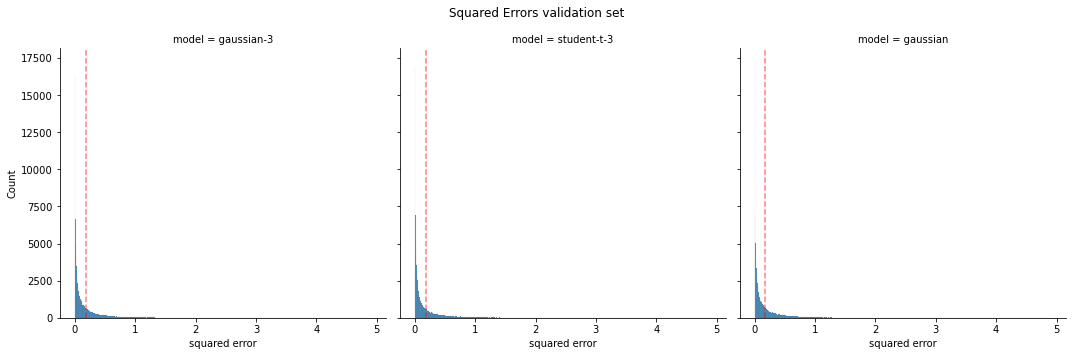

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
# We want to plot the MSE of the different models
g = sns.displot(MSE_df, x='squared error', col='model', facet_kws=dict(margin_titles=True), )
title = 'Squared Errors validation set'

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle(title)

def specs(x, **kwargs):
    avg = x.mean()
    print(avg)
    plt.axvline(avg, c="red", alpha=0.5, linestyle='--', label="mean: {}".format(round(avg, 2)))


g.map(specs, 'squared error')



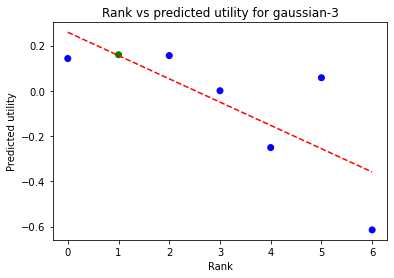

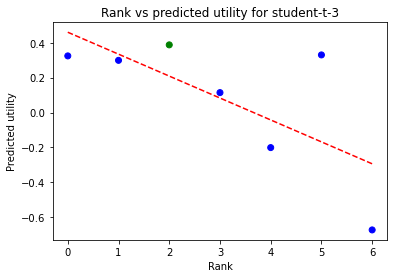

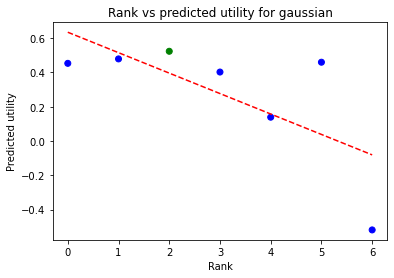

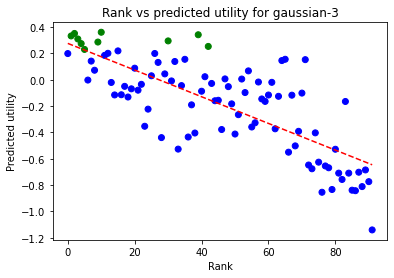

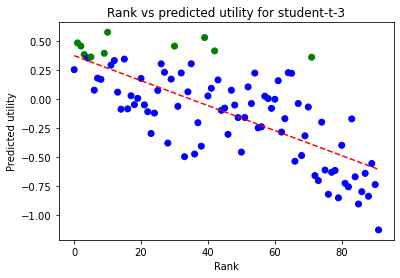

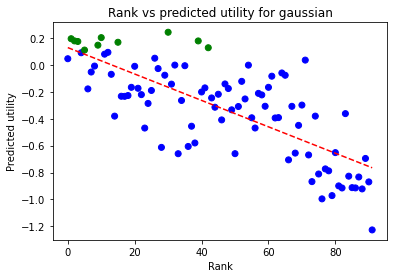

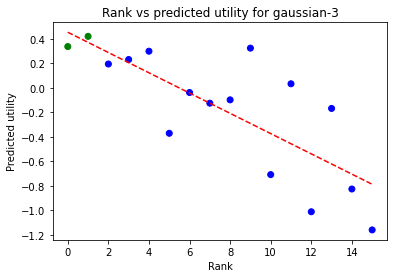

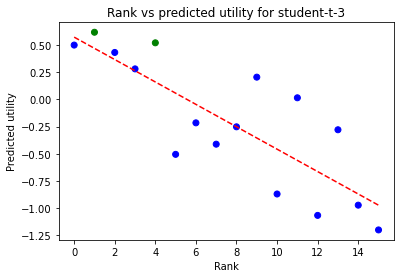

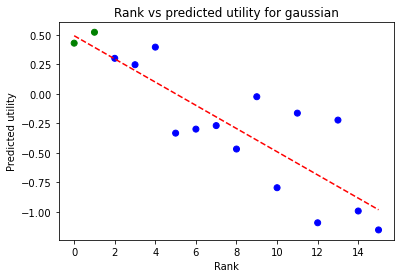

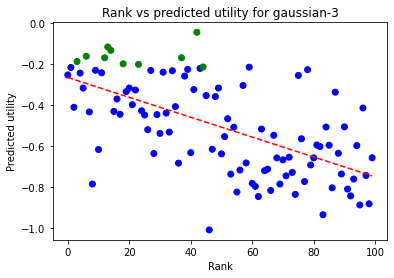

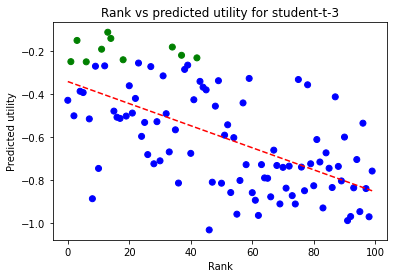

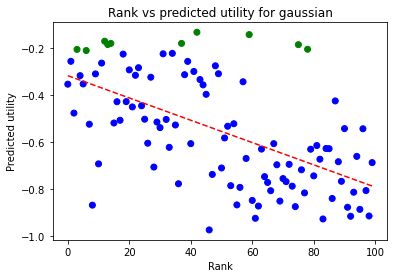

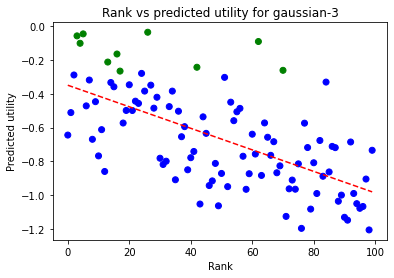

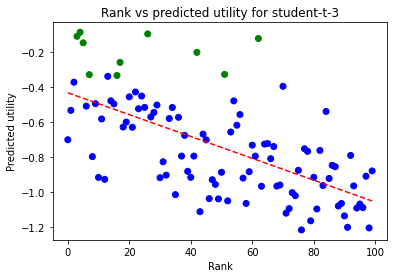

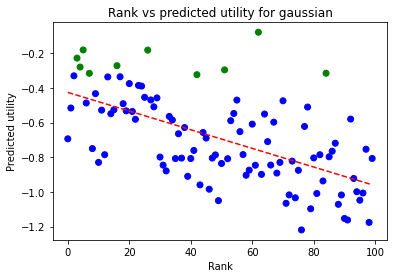

In [36]:
import matplotlib.pyplot as plt

np.random.seed(3)
indices = np.random.choice(2500, 5)
for i in indices:
    for name in models:
        row = dataset.iloc[i]


        predicted_means = np.array(row["{}-mean".format(name)])
        target_means = row["sample_mean"]

        sorted_indices = np.argsort(target_means)[::-1]

        predicted_means_sorted = predicted_means[sorted_indices]
        x = np.arange(0, len(predicted_means_sorted))

        sorted_indices_predicted = np.argsort(predicted_means_sorted)[::-1]

        colors = ["b"]  * len(predicted_means)

        top_10 = math.ceil(0.1 * len(sorted_indices_predicted)) 
        for j in range(top_10):
            c = sorted_indices_predicted[j]
            colors[c] = 'g'



        z = np.polyfit(x, predicted_means_sorted, 1)
        p = np.poly1d(z)
        plt.plot(x,p(x),"r--")






        plt.scatter(x, predicted_means_sorted, marker='o', c= colors,)
        plt.xlabel('Rank')
        plt.ylabel("Predicted utility")
        plt.title("Rank vs predicted utility for {}".format(name))


        plt.show()

    

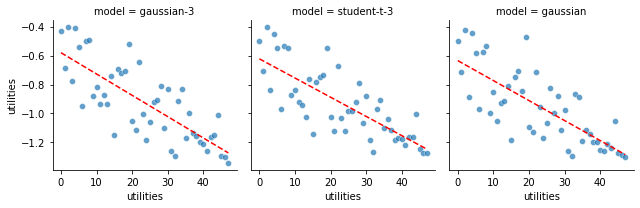

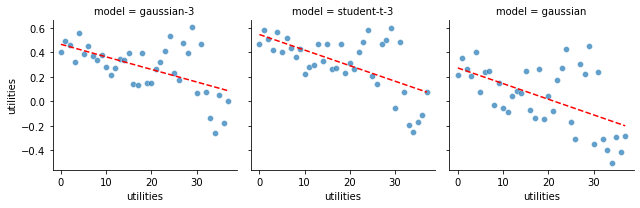

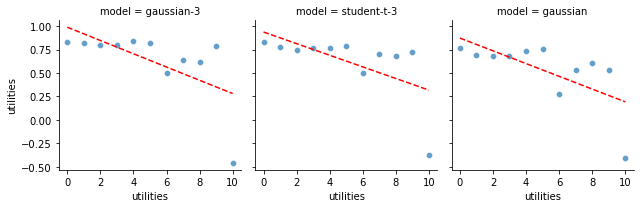

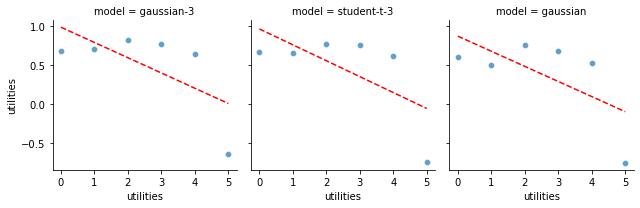

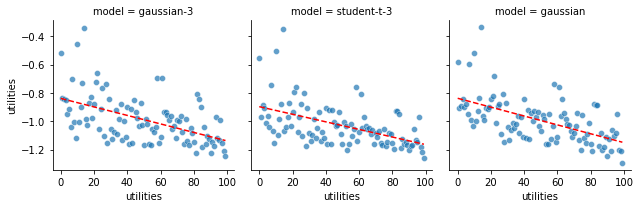

In [65]:


np.random.seed(0)
indices = np.random.choice(2500, 5)
for i in indices:
    sns.reset_orig()
    temp = {
        "utilities": [],
        "model": [],
        "rank": [],
        "colors": []
    }
    for name in models:
        row = dataset.iloc[i]


        predicted_means = np.array(row["{}-mean".format(name)])
        target_means = row["sample_mean"]

        sorted_indices = np.argsort(target_means)[::-1]

        predicted_means_sorted = predicted_means[sorted_indices]
        x = np.arange(0, len(predicted_means_sorted))

        sorted_indices_predicted = np.argsort(predicted_means_sorted)[::-1]

#         colors = ["b"]  * len(predicted_means)

#         top_10 = math.ceil(0.1 * len(sorted_indices_predicted)) 
#         for j in range(top_10):
#             c = sorted_indices_predicted[j]
#             colors[c] = 'g'

        colors = ["b"]  * len(predicted_means)

        top_10 = math.ceil(0.1 * len(sorted_indices_predicted)) 
        for j in range(top_10):
            c = sorted_indices_predicted[j]
            colors[c] = 'g'
        
        temp["utilities"] += predicted_means_sorted.tolist()
        temp["rank"] += x.tolist()
        temp["model"] += [name] * len(x)
        temp["colors"] += colors
        
    df = pd.DataFrame.from_dict(temp)
    
    g = sns.FacetGrid(df, col="model",)
    g.map(sns.scatterplot, "rank", "utilities", alpha=.7)
    
    
    def specs(utilities, **kwargs):
        ranks = np.arange(0, len(utilities))

        z = np.polyfit(ranks, utilities, 1)
        p = np.poly1d(z)
        
        plt.plot(ranks, p(ranks),"r--")

    g.map(specs, "utilities")



    






#     plt.scatter(x, predicted_means_sorted, marker='o', c= colors,)
#     plt.xlabel('Rank')
#     plt.ylabel("Predicted utility")
#     plt.title("Rank vs predicted utility for {}".format(name))


#     plt.show()

    

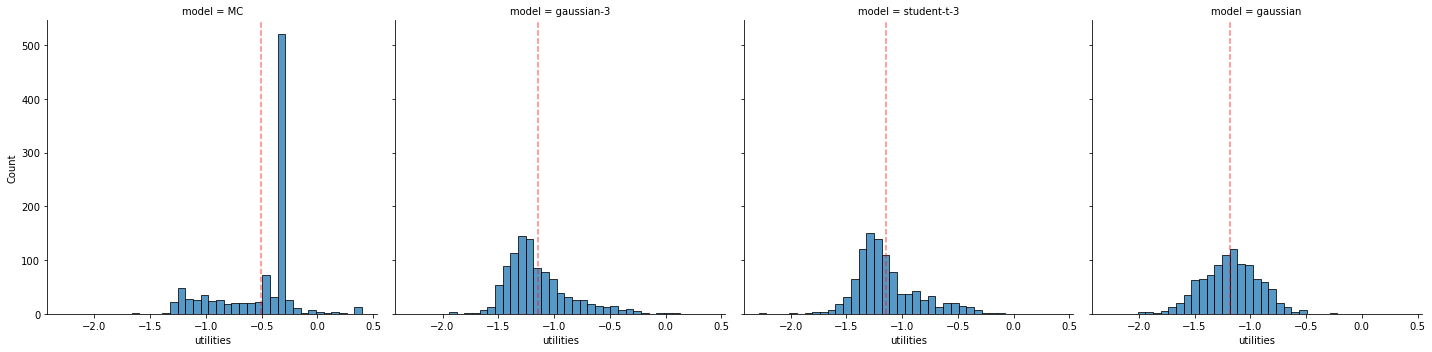

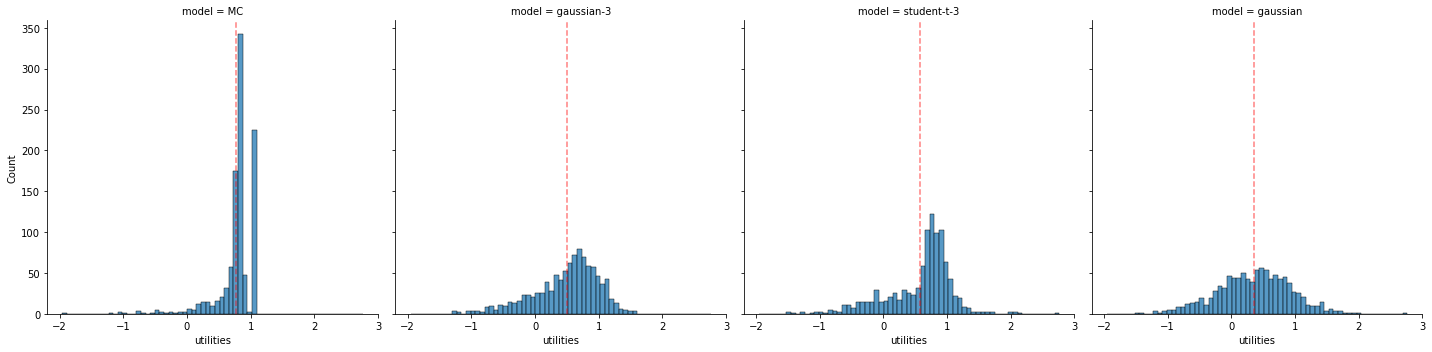

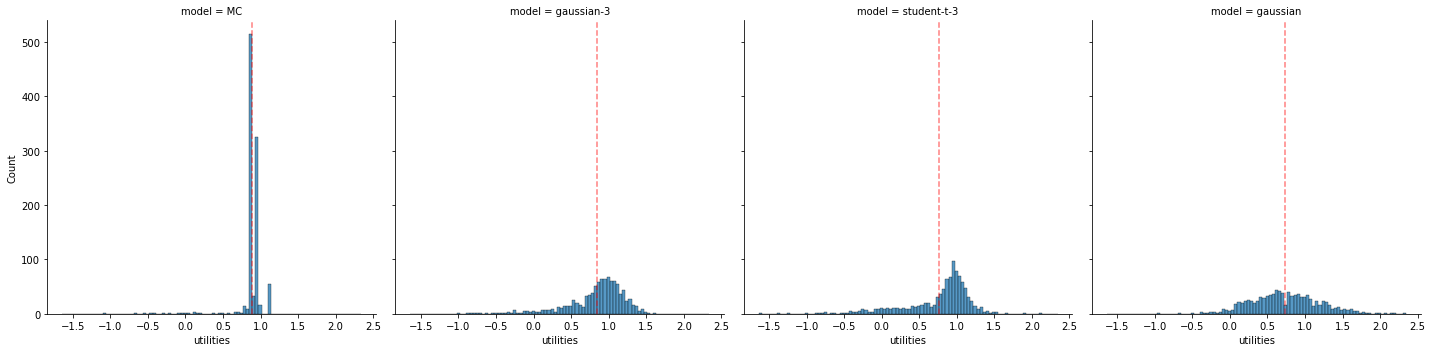

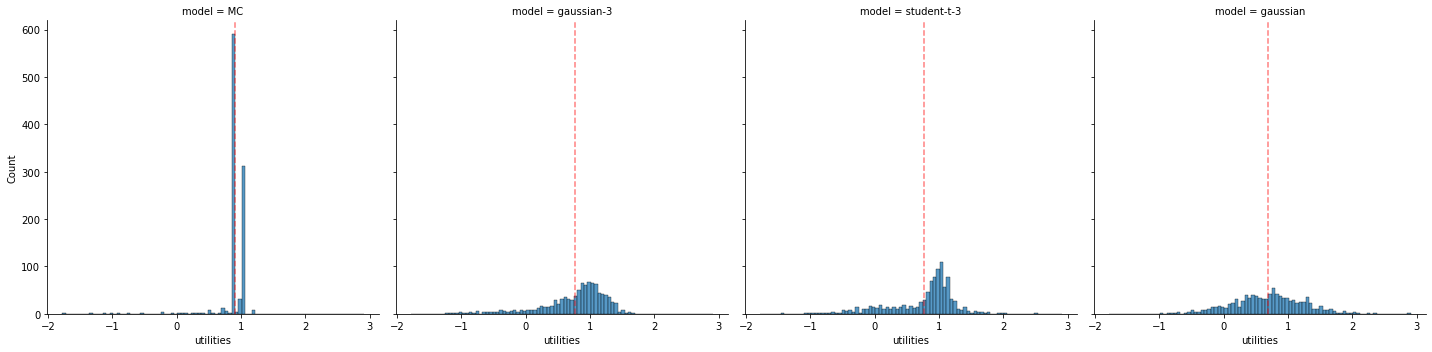

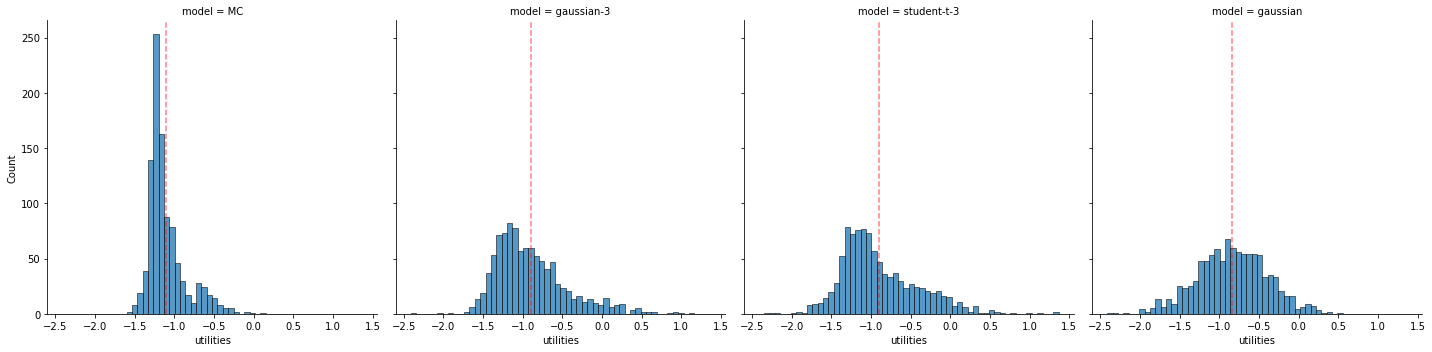

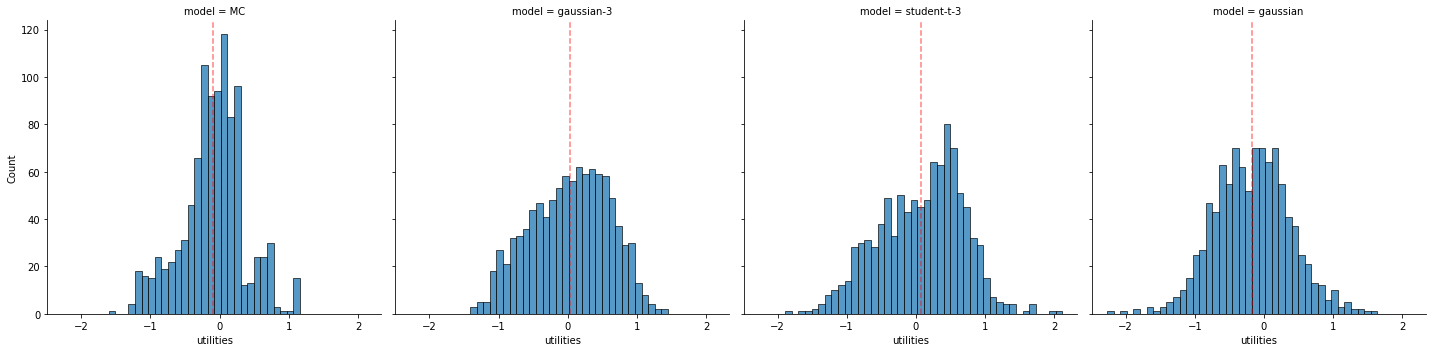

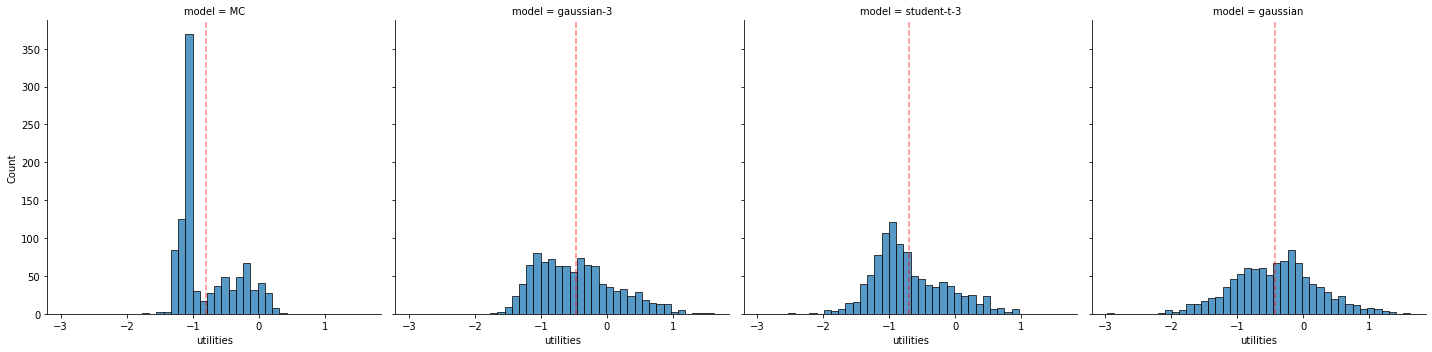

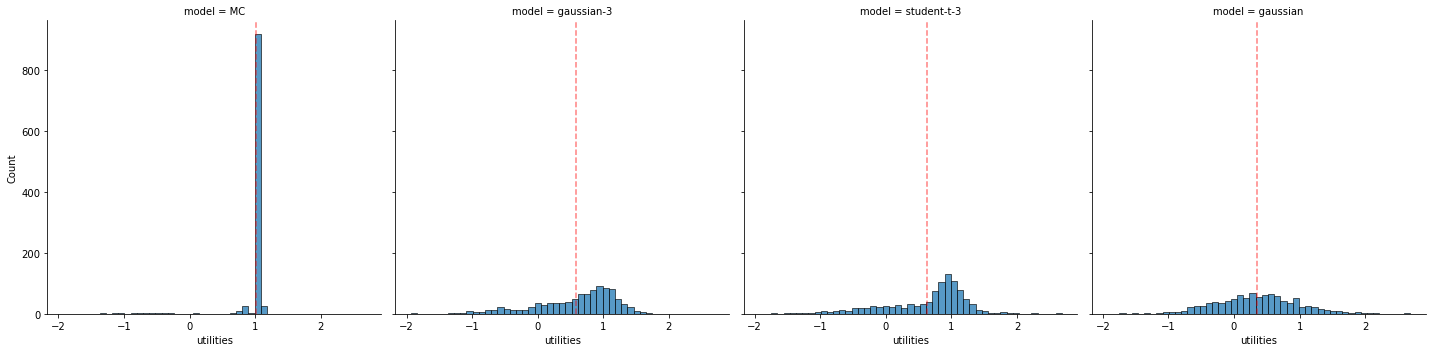

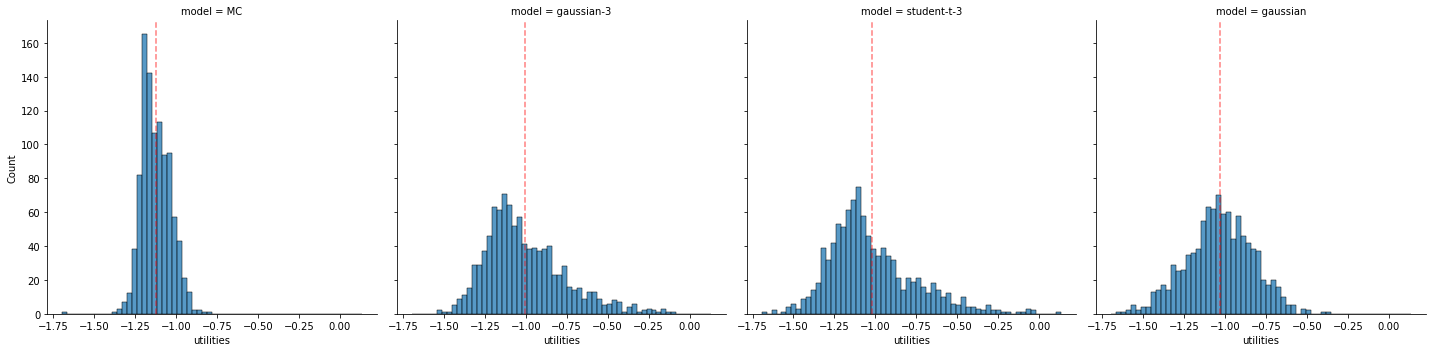

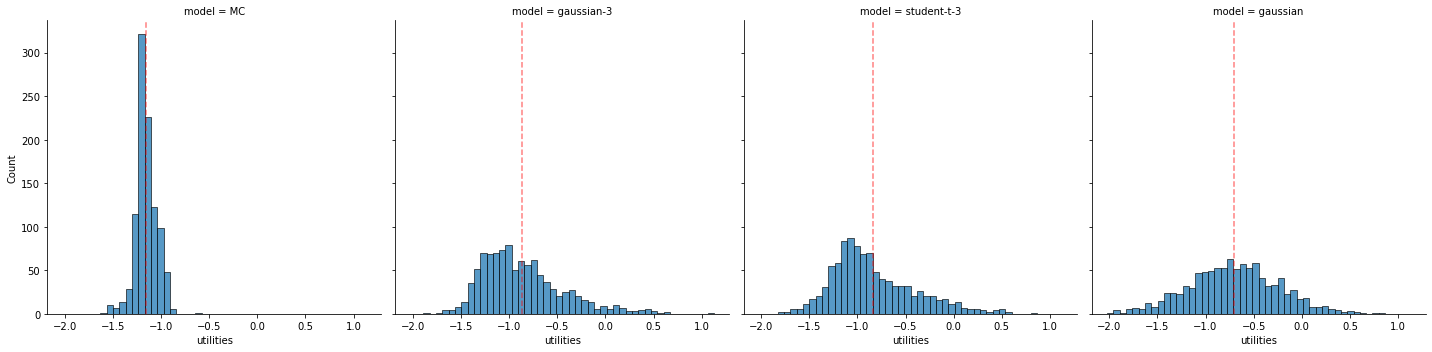

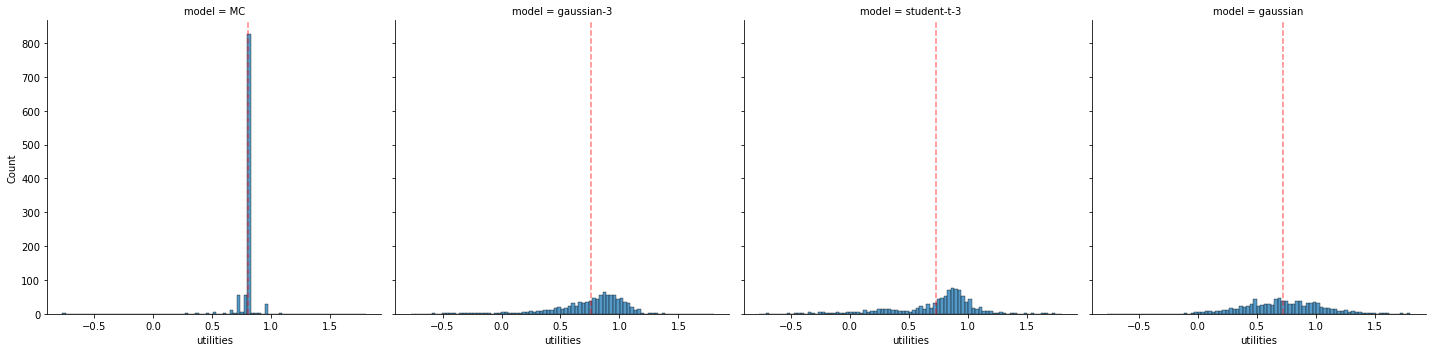

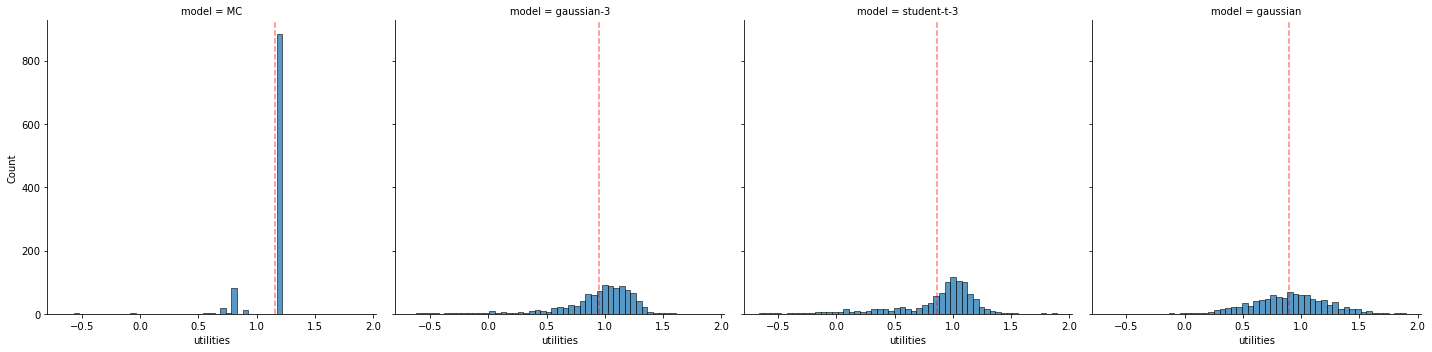

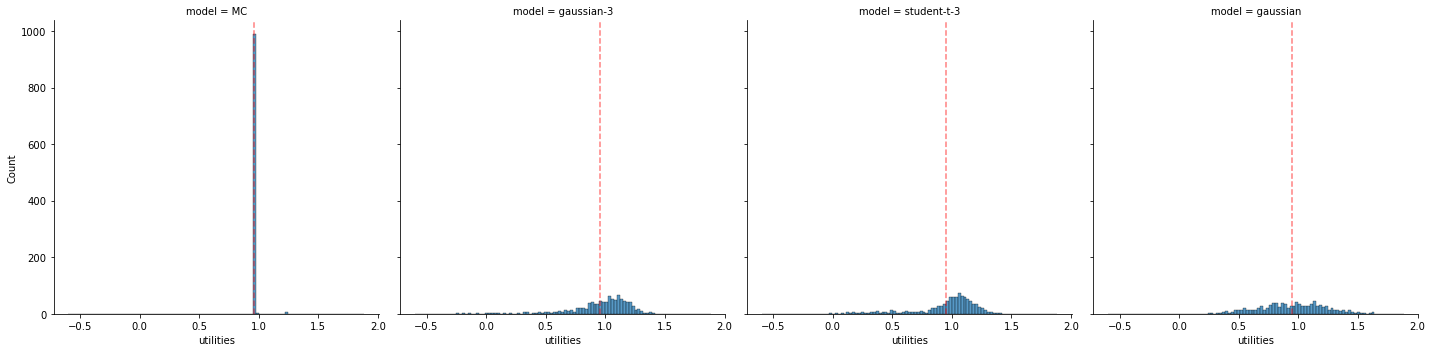

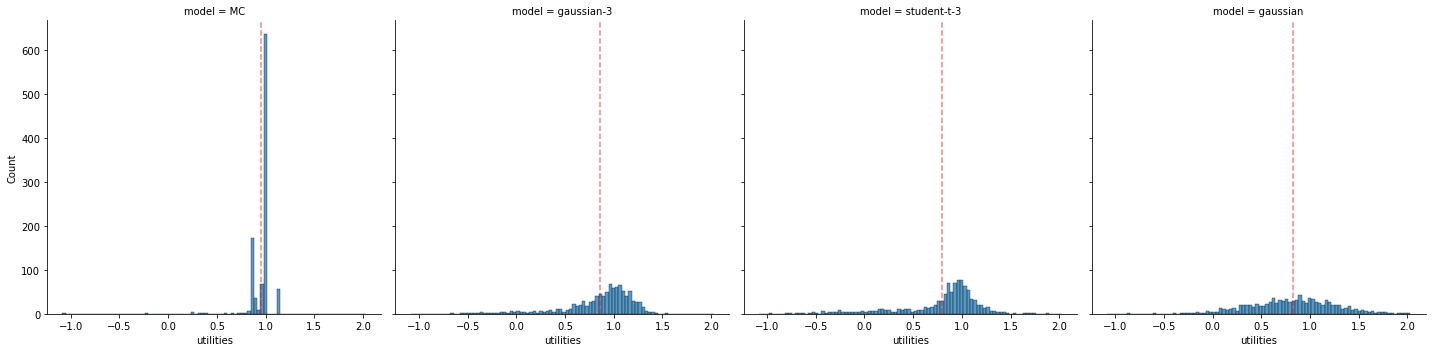

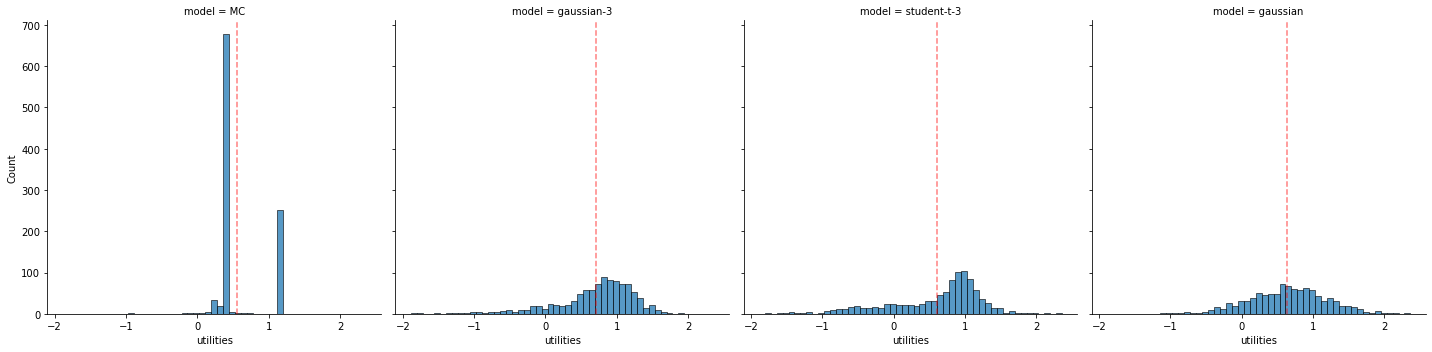

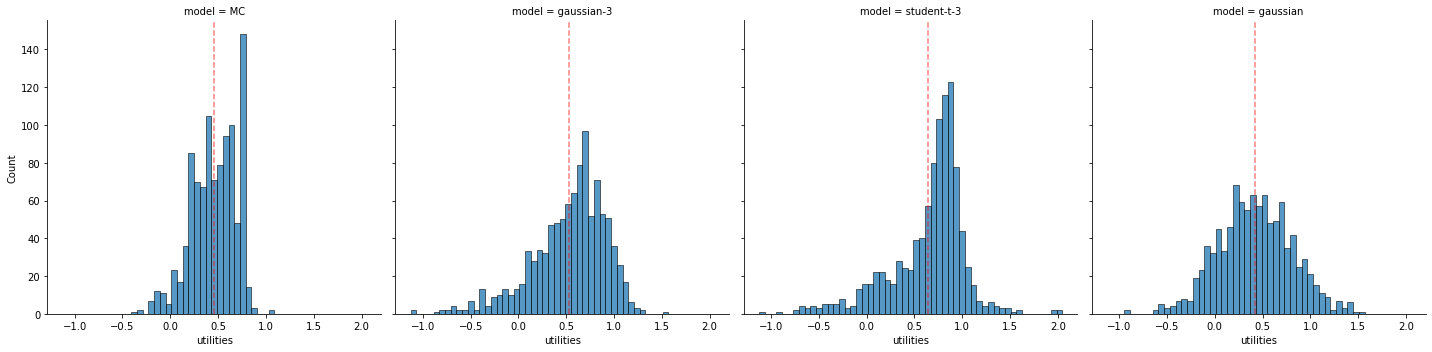

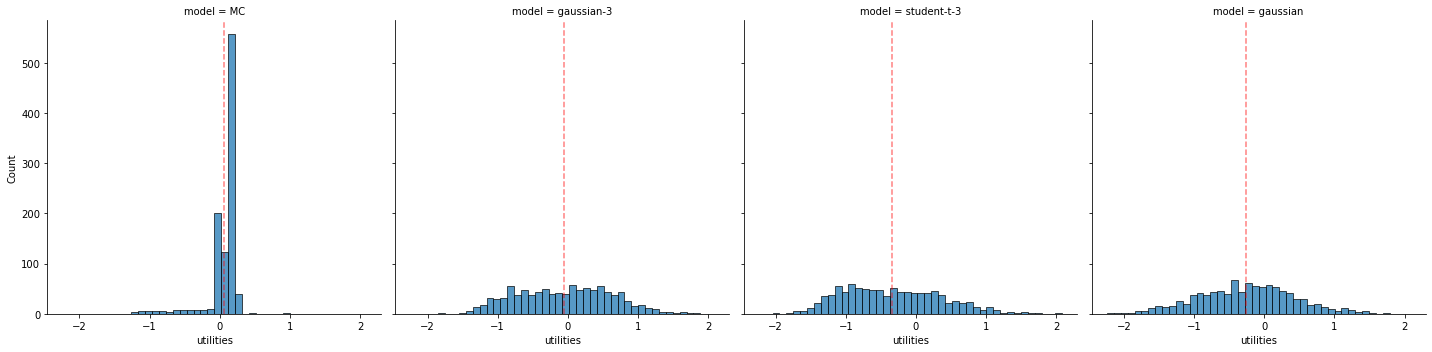

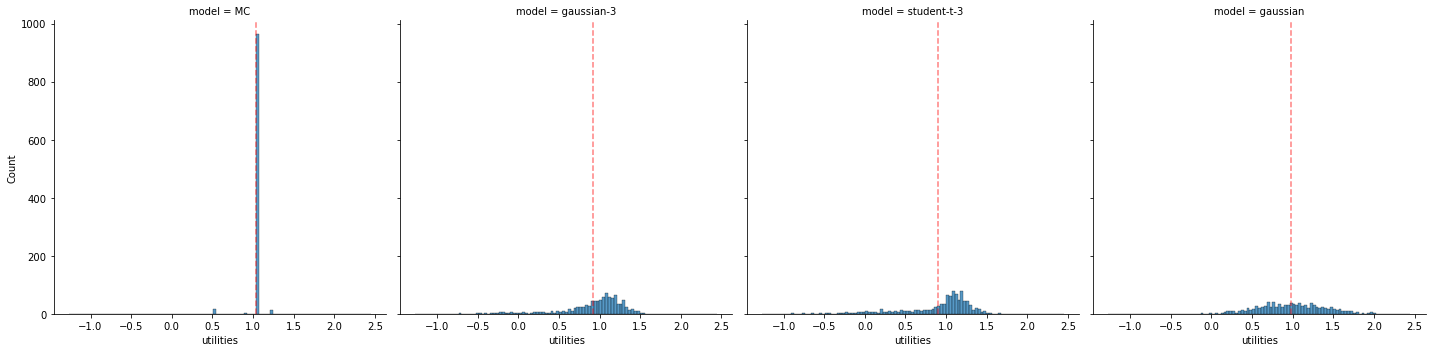

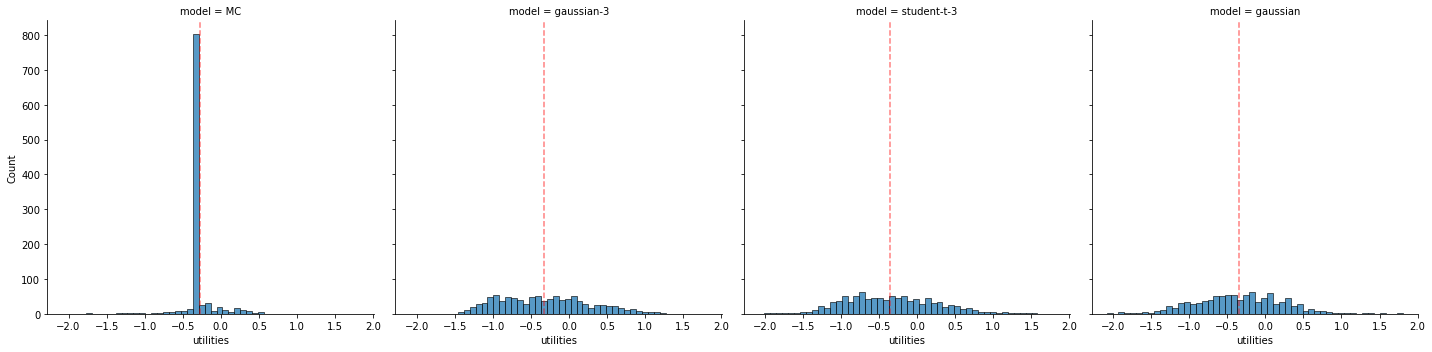

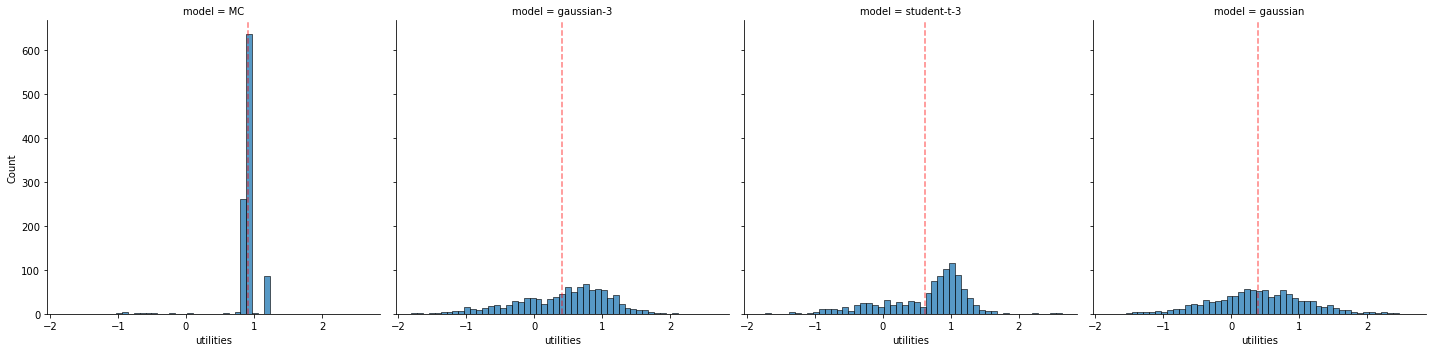

In [94]:

#Ploting the fits

np.random.seed(0)
indices = np.random.choice(2500, 20)
for i in indices:
    
    
    row = dataset.iloc[i]
    utilities = row["utilities"]
   
    j = np.random.choice(len(utilities), 1)[0]
    
    temp = {
        "utilities": [],
        "model": [],
    }
    
    utilities = utilities[j].tolist()
    counts = row["utilities_count"].tolist()
    repeated_utilities = []
    for u, c in zip(utilities, counts):
        repeated_utilities += [u] * c
    
    
    temp["utilities"] += repeated_utilities
    l = len(repeated_utilities)
    temp["model"] += ["MC"] * l
    
    for name in models:
       

        samples = np.array(row["{}-samples".format(name)])
        


        temp["utilities"] += samples[j].tolist()

        temp["model"] += [name] * l
        
        
    df = pd.DataFrame.from_dict(temp)
    
    
    g = sns.displot(df, x='utilities', col="model")

    def specs(x, **kwargs):
        avg = x.mean()
        plt.axvline(avg, c="red", alpha=0.5, linestyle='--', label="mean: {}".format(round(avg, 2)))

     
    g.map(specs, 'utilities')



